# Parallelized Sequential Gaussian Simulation

Sequential Gaussian Simulation (SGS) is a computationally intense interpolation technique with a complexity of $O(kN^4)$, thus generating models using SGS can take a lot of time. To reduce the time cost of SGS, we apply parallelization to the most expensive calculations, which divides the work among several CPU's, as opposed to running entirely on one CPU. Our parallelization strategy is applied to GStatSim's Non-stationary SGS with adaptive partitioning technique, which has additional benefits such as accounting for non-uniformity of spacial statistics, and a nearest neighbor octant search. Using parallelism, we achive a siginificant speedup compared to the serial approach.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import QuantileTransformer
import pyvista as pv
pv.set_jupyter_backend('ipyvtklink')

import sgs_preprocess
import sgs_alg
import sgs_plts

## User Parameters

Edit this cell to test algorithm on different dataset and/or at different resolutions.

* **file_name** - relative file path to csv dataset

* **x, y, z** - dataset column names for X, Y locations, and Bed elevation measurements, respectively

* **xmin, xmax, ymin, ymax** - geometric constrains for simulation (leave as *None* to default to min/max values in dataset)

* **res** - resolution of simulation in meters

In [2]:
file_name = 'Data/Greenland_data.csv'
x = 'X'
y = 'Y'
z = 'Bed'
xmin = None
xmax = None
ymin = None
ymax = None
res = 500

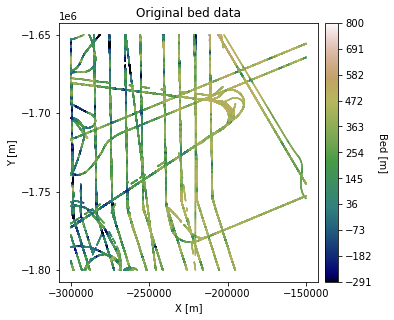

In [3]:
df_bed = pd.read_csv(file_name)

mu = np.mean(df_bed[z]); sd = np.std(df_bed[z])

sgs_plts.splot2D(df=df_bed, title='Original bed data', x=x, y=y, c=z, vmin = mu - 3*sd, vmax = mu + 3*sd)

## Grid and transform data

In [4]:
df_data, grid_matrix, df_nan = sgs_preprocess.grid_data(df_bed, xmin, xmax, ymin, ymax, res, x, y, z)

# normal score transformation
df_data.loc[:,'Norm_Bed'], nst_trans = sgs_preprocess.nscore(df_data, z)

Dataframe has 487726 points.
Gridded data has 90000 points, 91.3% (82185) are missing and will be simulated.


## Group data into different clusters using adaptive partioning

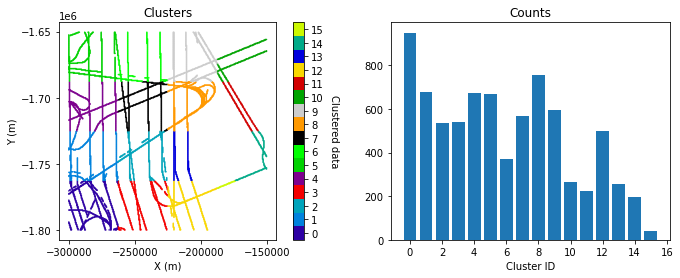

In [5]:
max_pts = 100           # maximum number of points in each cluster
min_len = 50000         # minimum side length of squares

df_data, i = sgs_preprocess.adaptive_partitioning(df_data, xmin, xmax, ymin, ymax, max_pts, min_len)

sgs_plts.plt_clusters(df_data)

## Define variogram parameters for each cluster in parallel

Variograms are fit to a subset of data within each cluster simulataneous by dividing the proccess among multiple CPUs. 

In [6]:
# get number of processes to use
processes = int(os.cpu_count())

max_lag = 30000         # maximum lag distance
n_lags = 100            # number of bins

gamma = sgs_preprocess.get_variograms(df_data, n_lags, max_lag, processes)


Getting parallel variograms...
	3.0 seconds to complete



## Parallel nearest neigbors and kriging weights calculation

In this step we prepare all the data required to simulate bed elevation values. The **kriging_weights** function calls functions that are executed in parallel. Thus, the calculations to obtain auxiliary data for each grid cell are divided among multiple CPU's. The following is performed in a parallel for loop:

For each grid cell in random path:

1. Find the locations of the nearest neighbors from a subset containing observed data and former grid cells in random path.

2. Randomly select cluster value assigned to a nearest neighbor.

3. Look up the variogram parameters associated with that cluster.

4. Use variogram parameters and nearest neighbor locations to calculate kriging weighs

The **kriging_weights** function then returns a dictionary containing the kriging weights and indicies of nearest neighbors for each grid cell in random path.


In [7]:
# define random path by shuffling order in which points are simulated 
df_nan = sgs_preprocess.shuffle_pred_grid(df_nan)

max_num_nn = 50     # maximum number of nearest neighbors
rad = 30000         # search radius

kr_dictionary = sgs_alg.kriging_weights(df_data, df_nan, gamma, rad, max_num_nn, res, processes, x, y, 'Norm_Bed', 'cluster')

Parallel simulation with 8 processes...
	87.3 seconds to complete 



## Simulate bed elevation values

Using the kriging weights and inidicies of nearest neighbors obtained in the previous step, **sgs_pred_Z** finds the kringing mean and variance and samples from a gaussian distribution defined by these parameters. This random variate is the simulated bed elevation value. 

In [8]:
# simulate
data_xyzk, pred_xyzk = sgs_alg.sgs_pred_Z(kr_dictionary, df_data, df_nan, gamma, x, y, 'Norm_Bed', 'cluster')

Starting sequential simulation...
	6.97 seconds to complete



In [9]:
# concatenate data frames
df_sim = sgs_alg.concat(data_xyzk ,pred_xyzk)

# reverse normal score transformation
tmp = df_sim['Norm_Bed'].values.reshape(-1,1)
df_sim[z] = nst_trans.inverse_transform(tmp)

## Plot simulation 

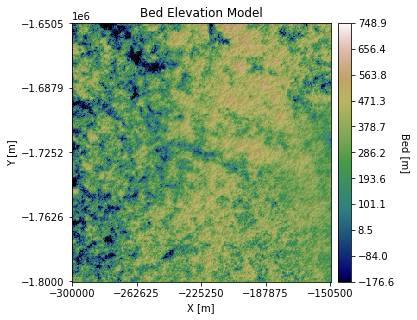

In [10]:
# 2D hillshade topographic plot
mu = np.mean(df_sim[z]); sd = np.std(df_sim[z])
vmin = mu - 3*sd ; vmax = mu + 3*sd

xmin = np.min(df_bed[x]); xmax = np.max(df_bed[x])
ymin = np.min(df_bed[y]); ymax = np.max(df_bed[y])

grid_xy, rows, cols = sgs_plts.prediction_grid(xmin, xmax, ymin, ymax, res)


sgs_plts.mplot1(grid_xy, df_sim[[z]].to_numpy(), rows, cols, "Bed Elevation Model", vmin = vmin, vmax = vmax, hillshade=True)

In [11]:
# 3D interactive topographic visualization using PyVista
df_ele = df_sim[[x,y,z]]

cmap = plt.cm.get_cmap("gist_earth")

mesh = pv.PolyData(df_ele.to_numpy())
fill = mesh.delaunay_2d()
fill.point_data["Elevation"] = df_ele[z]
warped = fill.warp_by_scalar("Elevation", factor = 5) 
warped.plot(lighting = True, cmap=cmap, clim = (vmin, vmax))


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Simulation for Pine Island Glaciar

In [12]:
file_name = 'Data/PIG_data.csv'
x = 'x'
y = 'y'
z = 'bedrock_altitude (m)'
xmin = None
xmax = None
ymin = None
ymax = None
res = 500

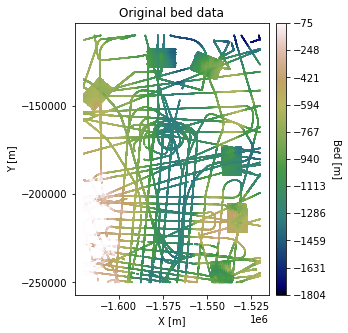

In [13]:
df_bed = pd.read_csv(file_name)

mu = np.mean(df_bed[z]); sd = np.std(df_bed[z])

sgs_plts.splot2D(df=df_bed, title='Original bed data', x=x, y=y, c=z, vmin = mu - 3*sd, vmax = mu + 3*sd)

In [14]:
df_data, grid_matrix, df_nan = sgs_preprocess.grid_data(df_bed, xmin, xmax, ymin, ymax, res, x, y, z)

# normal score transformation
df_data.loc[:,'Norm_Bed'], nst_trans = sgs_preprocess.nscore(df_data, z)

Dataframe has 840033 points.
Gridded data has 56000 points, 72.7% (40725) are missing and will be simulated.


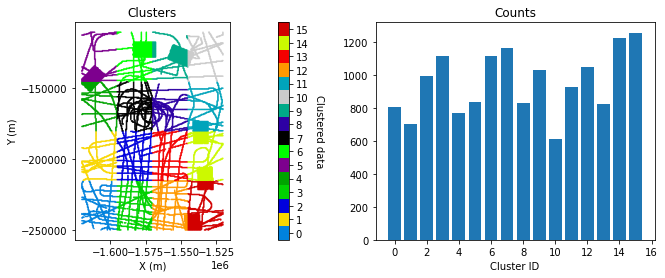

In [15]:
max_pts = 100           # maximum number of points in each cluster
min_len = 30000         # minimum side length of squares (CHANGED)

df_data, i = sgs_preprocess.adaptive_partitioning(df_data, xmin, xmax, ymin, ymax, max_pts, min_len)

sgs_plts.plt_clusters(df_data)

In [16]:
# get number of processes to use
processes = int(os.cpu_count())

max_lag = 30000         # maximum lag distance
n_lags = 100            # number of bins

gamma = sgs_preprocess.get_variograms(df_data, n_lags, max_lag, processes)


Getting parallel variograms...
	4.06 seconds to complete



In [17]:
# define random path by shuffling order in which points are simulated 
df_nan = sgs_preprocess.shuffle_pred_grid(df_nan)

max_num_nn = 50     # maximum number of nearest neighbors
rad = 30000         # search radius

kr_dictionary = sgs_alg.kriging_weights(df_data, df_nan, gamma, rad, max_num_nn, res, processes, x, y, 'Norm_Bed', 'cluster')

Parallel simulation with 8 processes...
	42.27 seconds to complete 



In [18]:
# simulate
data_xyzk, pred_xyzk = sgs_alg.sgs_pred_Z(kr_dictionary, df_data, df_nan, gamma, x, y, 'Norm_Bed', 'cluster')

Starting sequential simulation...
	3.32 seconds to complete



In [19]:
# concatenate data frames
df_sim = sgs_alg.concat(data_xyzk ,pred_xyzk)

# reverse normal score transformation
tmp = df_sim['Norm_Bed'].values.reshape(-1,1)
df_sim[z] = nst_trans.inverse_transform(tmp)

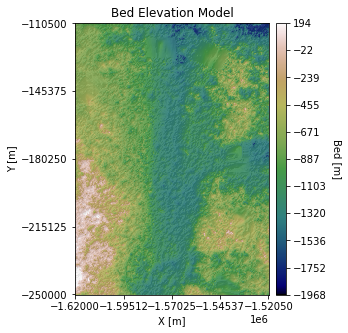

In [20]:
# 2D hillshade topographic plot
mu = np.mean(df_sim[z]); sd = np.std(df_sim[z])
vmin = mu - 3*sd ; vmax = mu + 3*sd

xmin = np.min(df_bed[x]); xmax = np.max(df_bed[x])
ymin = np.min(df_bed[y]); ymax = np.max(df_bed[y])

grid_xy, rows, cols = sgs_plts.prediction_grid(xmin, xmax, ymin, ymax, res)


sgs_plts.mplot1(grid_xy, df_sim[[z]].to_numpy(), rows, cols, "Bed Elevation Model", vmin = vmin, vmax = vmax, hillshade=True)

In [21]:
# 3D interactive topographic visualization using PyVista
df_ele = df_sim[[x,y,z]]

cmap = plt.cm.get_cmap("gist_earth")

mesh = pv.PolyData(df_ele.to_numpy())
fill = mesh.delaunay_2d()
fill.point_data["Elevation"] = df_ele[z]
warped = fill.warp_by_scalar("Elevation", factor = 3)
warped.plot(lighting = True, cmap=cmap, clim = (vmin, vmax))

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)